Para abrir o notebook no Google Colab, altere o domínio `github.com` para `githubtocolab.com`

<div class="alert alert-block alert-danger">
Para praticar programação, é importante que você erre, leia as mensagens de erro e tente corrigí-los.
    
Dessa forma, no Google Colab, é importante que você DESATIVE OS RECURSOS DE AUTOCOMPLETAR:

- Menu Ferramentas -> Configurações
- Na janela que é aberta:
  - Seção Editor -> Desativar "Mostrar sugestões de preenchimento de código com base no contexto"
  - Seção Assistência de IA -> Desabilitar itens

Na versão em inglês:

- Menu Tools -> Settings
- Na janela que é aberta:
  - Seção Editor -> Desativar "Show context-powered code completions"
  - Seção AI Assistance -> Desabilitar itens
</div>

# PSI5892 - Aula de Exercícios

# MLP genérica para solução do problemas das meias luas

Neste exercício vamos treinar uma rede MLP com o algorotimo backpropagation para a solução do problema das meias luas.

In [51]:
import numpy as np
import matplotlib.pyplot as plt

Vamos gerar os dados de treinamento do problema das meias-luas.

In [52]:
def meias_luas(NA, NB, r1, r2, r3):
    """
    dados = meias_luas(NA,NB,r1,r2,r3)
    NA: número de pontos da região A
    NB: número de pontos da região B
    r1, r2 e r3: dados das meias-luas
    """

    # total de dados de treinamento
    Nt = NA + NB

    # dados das meia luas
    rmin = r1 - r3 / 2
    rmax = r1 + r3 / 2

    # Pontos da Região A
    a = np.pi * np.random.rand(NA, 1)
    rxy = np.random.uniform(rmin, rmax, (NA, 1))
    x1A = rxy * np.cos(a)
    x2A = rxy * np.sin(a)
    dA = np.ones((NA, 1))
    pontosA = np.hstack((x1A, x2A, dA))

    # Pontos da Região B
    a = np.pi * np.random.rand(NB, 1)
    rxy = np.random.uniform(rmin, rmax, (NB, 1))
    x1B = rxy * np.cos(a) + r1
    x2B = -rxy * np.sin(a) - r2
    dB = -np.ones((NB, 1))
    pontosB = np.hstack((x1B, x2B, dB))

    # Concatenando e embaralhando os dados
    dados = np.vstack((pontosA, pontosB))
    np.random.shuffle(dados)

    # Figura para mostrar os dados de treino
    fig, ax1 = plt.subplots()
    ax1.plot(x1A, x2A, ".b")
    ax1.plot(x1B, x2B, ".r")
    plt.xlabel("x_1")
    plt.ylabel("x_2")
    plt.grid(axis="x", color="0.5")
    plt.grid(axis="y", color="0.5")

    return dados

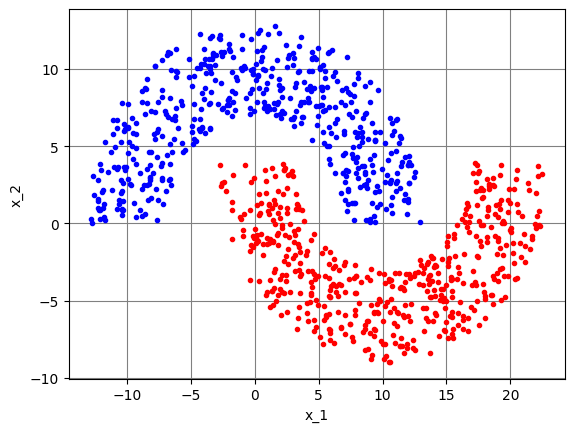

In [53]:
# número de pontos de treinamento da Região A
NA = 500

# número de pontos de treinamento da Região B
NB = 500

# número total de dados de treinamento
Nt = NA + NB

r1 = 10
r3 = 6
r2 = -4

dados_treino = meias_luas(NA, NB, r1, r2, r3)

In [54]:
# organizando os dados para entrada da MLP

# sinal de entrada
x = dados_treino[:, [0, 1]]

# sinal desejado
d = dados_treino[:, [2]]

print(x.shape)
print(d.shape)

(1000, 2)
(1000, 1)


# Exercício 1

Implemente uma função para treinamento de uma rede MLP genérica usando o algoritmo do gradiente estocástico, considerando a função de ativação $f(x) = \textnormal{tanh}(x)$ com derivada $f'(x) = 1 - \textnormal{tanh}^2(x)$.

Para definir a estrutura da rede, utilize uma entrada chamada `Nn` contendo o número de entradas da rede, seguido do número de neurônios de cada camada. Por exemplo: `Nn = [2, 3, 2, 1]` representa uma rede com duas entradas, duas camadas ocultas com 3 e 2 neurônios, respectivamente e um único neurônio na camada de saída.

Considere a seguinte assinatura para a função:

```python
def redeMLP_SGD(x, d, Nn, eta, Nt, Nb, Ne, W0):
    """
    Entradas:
    x: sinal de entrada
    d: sinal desejado
    Nn: vetor que contém o número de neurônios em cada camada,
        mas na posição 0, contém o número de entradas da rede
    eta: passo de adaptação
    Nt: número de dados de treinamento
    Nb: tamanho do mini-batch
    Ne: número de épocas
    W0: matriz de pesos iniciais (inclui o bias)
        utilize um tensor de dimensões np.max(Nn) x np.max(Nn) + 1 x L
        para armazenar os pesos, sendo L o número de camadas da rede
    Saídas:
    J_MSE: valor da função custo ao longo das épocas
    W: matriz de pesos (inclui o bias) da última época
       utilize um tensor de mesmas dimensões de W0
    """
```

Após implementação da função para treinamento, treine uma rede para solucionar o problemas das meias luas considerando os dados `x`e `d` criados anteriormente. Faça um gráfico da função custo ao longo das épocas de treinamento.

## Resolução

In [55]:
# Vou utilizar a tangente hiperbólica do próprio numpy:
# np.tanh()

def redeMLP_SGD(x, d, Nn, eta, Nt, Nb, Ne, W0):
    """
    Entradas:
    x: sinal de entrada
    d: sinal desejado
    Nn: vetor que contém o número de neurônios em cada camada,
        mas na posição 0, contém o número de entradas da rede
    eta: passo de adaptação
    Nt: número de dados de treinamento
    Nb: tamanho do mini-batch
    Ne: número de épocas
    W0: matriz de pesos iniciais (inclui o bias)
        utilize um tensor de dimensões np.max(Nn) x np.max(Nn) + 1 x L
        para armazenar os pesos, sendo L o número de camadas da rede
    Saídas:
    J_MSE: valor da função custo ao longo das épocas
    W: matriz de pesos (inclui o bias) da última época
        utilize um tensor de mesmas dimensões de W0
    """

    # d está entre -1 e 1 -> usar tanh para classificação na camada de saída

    # Número de camadas com pesos (desconsidera a camada de entrada)
    L = len(Nn) - 1

    # Número de mini-batches (total / tamanho do mini-batch)
    Nmb = int(np.floor(Nt / Nb))

    # Lista para guardar os custos por época
    J_MSE = []

    # Copia os pesos iniciais (incluindo o bias) para não modificá-los
    W = np.copy(W0)

    # Adiciona coluna de 1's (bias) na primeira coluna de x
    x = np.hstack((np.ones((Nt, 1)), x))

    # Transforma d em um vetor coluna (Nt, 1)
    d = d.reshape(-1, 1)

    # Junta features e rótulos para um embaralhamento (x e d)
    Xd = np.hstack((x, d))

    # Loop para as épocas
    for k in range(Ne):

        # Embaralha os dados no início da época
        np.random.shuffle(Xd)

        # Separa os dados em entrada e saída desejada
        x_epoca = Xd[:, :-1]
        d_epoca = Xd[:, [-1]] # coluna de rótulos (a última de Xd)

        # Acumulador para o custo
        custo_epoca_total = 0.0

        # Loop para os mini-batches
        for l in range(Nmb):

            # Pega dados do mini-batch atual
            inicio = l * Nb                  # índice inicial atual do lote
            fim = (l + 1) * Nb               # índice final atual lote
            xmb = x_epoca[inicio:fim, :]     # entradas do lote atual
            dmb = d_epoca[inicio:fim, :]     # saídas desejadas do lote atual

            V = {}        # Guarda a saída do combinador linear (W @ Y)
            Y = {}        # Será a saída de ativação (phi(V))
            Y_bias = {}   # Entrada para a camada i+1

            # Entrada da camada 1 (com bias)
            Y_bias[0] = xmb.T

            # Loop para as camadas ocultas (itera da 1ª até a última (L))
            for i in range(1, L + 1):

                # índice do tensor de pesos
                l_idx = i - 1

                # Exemplo: Nn = [2, 2, 3, 1] -> Nn[0] é a camada 0.
                n_in = Nn[l_idx] + 1 # Nº de neurônios da camada anterior + bias
                n_out = Nn[i]        # Nº de neurônios da camada atual

                # Extrai a matriz de pesos do tensor
                Wi = W[:n_out, :n_in, l_idx]

                # Cálculo progressivo
                V[i] = Wi @ Y_bias[i-1] # Combinador linear
                Y[i] = np.tanh(V[i])    # Saída de ativação

                # Se não for a última camada
                if i < L:
                    # Adiciona bias
                    Y_bias[i] = np.vstack((np.ones((1, Nb)), Y[i]))
                else:
                    # Na última camada, não existe uma próxima camada
                    Y_bias[i] = Y[i]

            # Cálculo do custo
            emb = dmb.T - Y[L]                   # Erro do mini-batch (Y[L] é a saída da rede)
            custo_epoca_total += np.mean(emb**2) # MSE

            # Cálculo regressivo
            delta = {} # Para guardar os gradientes locais

            # Camada de saída (L)
            phi_prime_L = 1 - np.power(Y[L], 2) # Derivada da tanh
            delta[L] = emb * phi_prime_L        # O gradiente local é o produto entre o erro e a derivada da função de ativação

            # Camadas ocultas
            for i in reversed(range(1, L)):

                l_idx = i

                # Pega os pesos da camada seguinte
                n_in_next = Nn[i] + 1
                n_out_next = Nn[i+1]
                W_next = W[:n_out_next, :n_in_next, l_idx]

                phi_prime_i = 1 - np.power(Y[i], 2)

                # Propaga o erro para trás
                delta[i] = (W_next[:, 1:].T @ delta[i+1]) * phi_prime_i

            # Atualização dos pesos de todas as camadas
            for i in range(1, L + 1):
                l_idx = i - 1
                n_in = Nn[l_idx] + 1
                n_out = Nn[i]

                # Calcula o gradiente médio para o mini-batch
                gradiente = (1/Nb) * (delta[i] @ Y_bias[i-1].T)

                # Atualiza a fatia do tensor 3D de pesos
                W[:n_out, :n_in, l_idx] += eta * gradiente

        # Guarda o custo médio da época
        J_MSE.append(custo_epoca_total / Nmb)

    # Retorna a lista de custos e pesos treinados
    return J_MSE, W


In [56]:
# Parâmetros
Nn = [x.shape[1], 3, 2, 1] # Arquitetura da rede [Entradas, Camada 1, Camada 2, Saída]
eta = 0.1                  # Taxa de aprendizado
Nt = x.shape[0]            # Número de dados de treinamento
Nb = 50                    # Tamanho do mini-batch
Ne = 10000                 # Número de épocas
L = len(Nn) - 1            # Número de camadas de pesos

# Inicialização dos pesos
max_n = np.max(Nn)
np.random.seed(42)
# Cria o tensor 3D de pesos
W0 = np.random.randn(max_n, max_n + 1, L)

# Utiliza a iniciação de Xavier/Glorot que ajuda a evitar mínimos locais
for l in range(L):
    n_in = Nn[l]
    n_out = Nn[l+1]

    lim = np.sqrt(6 / (n_in + n_out))
    # Redefine os pesos da fatia
    W0[:n_out, :(n_in + 1), l] = np.random.uniform(-lim, lim, (n_out, n_in + 1))


print("Iniciando o treinamento da rede")
J_MSE, W_final = redeMLP_SGD(x, d, Nn, eta, Nt, Nb, Ne, W0)

print("Treinamento concluído.")
print(f"Custo (MSE) final após {Ne} épocas: {J_MSE[-1]:.6f}")

Iniciando o treinamento da rede
Treinamento concluído.
Custo (MSE) final após 10000 épocas: 0.000005


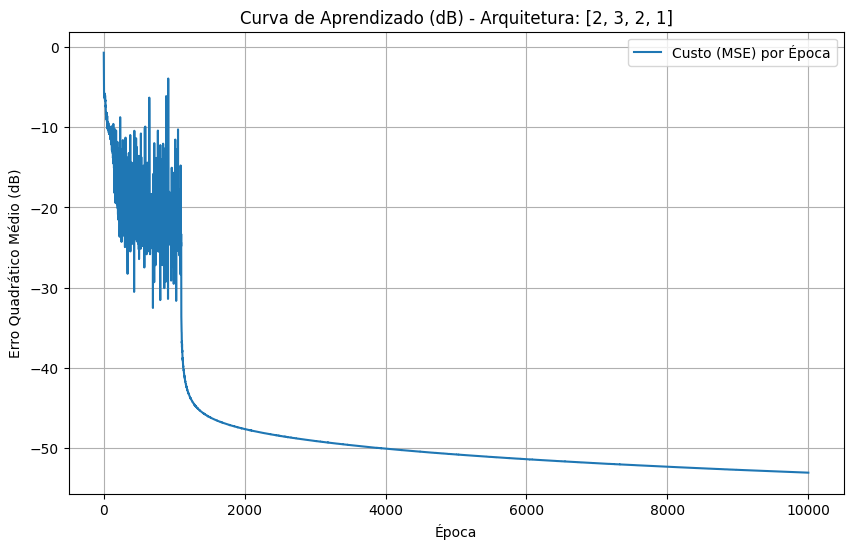

In [57]:

# Curva de aprendizado (em decibéis)
J_MSE_dB = 10 * np.log10(np.array(J_MSE))

plt.figure(figsize=(10, 6))
plt.plot(range(1, Ne + 1), J_MSE_dB, label='Custo (MSE) por Época')
plt.xlabel('Época')
plt.ylabel('Erro Quadrático Médio (dB)')
plt.title(f'Curva de Aprendizado (dB) - Arquitetura: {Nn}')
plt.grid(True)
plt.legend()
plt.show()

# Exercício 2

Utilizando os seguintes dados de teste:

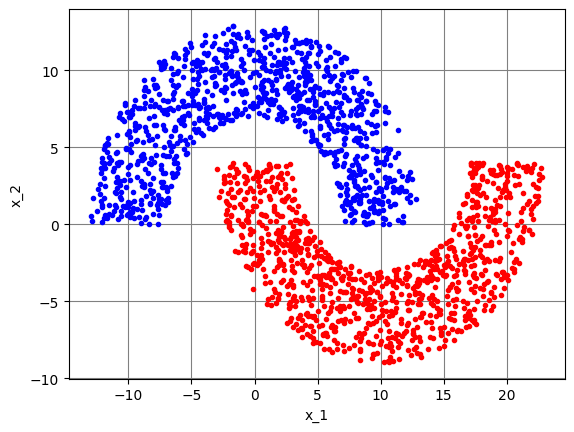

In [58]:
# Dados de teste
NAt = 1000
NBt = 1000
Nteste = NAt + NBt

dados_teste = meias_luas(NAt, NBt, r1, r2, r3)

# entrada
xteste = dados_teste[:, 0:2]  # sinal de entrada

# sinal desejado
dteste = dados_teste[:, 2].reshape(-1, 1)

Implemente uma função para teste da rede MLP treinada anteriormente, com a seguinte assinatura:

``` python
def redeMLP_teste(x, d, W, Nn, Nteste):
    """
    Entradas:
    x: sinal de entrada
    d: sinal desejado
    W: matriz de pesos (inclui o bias) da última época (mesmo formato do treinamento)
    Nn: vetor que contém o número de neurônios em cada camada,
        mas na posição 0, contém o número de entradas da rede
    Nteste: número de dados de teste
    Saídas:
    J_MSE: valor da função custo no teste
    y: saída da rede MLP
    """
```

Em seguida, faça o teste da rede com os dados de teste, apresente a taxa de erro e a curva de separação das duas regiões obtidas com a rede treinada.

## Resolução

In [59]:
def redeMLP_teste(x, d, W, Nn, Nteste):
    """
    Entradas:
    x: sinal de entrada
    d: sinal desejado
    W: matriz de pesos (inclui o bias) da última época (mesmo formato do treinamento)
    Nn: vetor que contém o número de neurônios em cada camada,
        mas na posição 0, contém o número de entradas da rede
    Nteste: número de dados de teste
    Saídas:
    J_MSE: valor da função custo no teste
    y: saída da rede MLP
    """

    # Adiciona coluna de 1's (bias)
    x_bias = np.hstack((np.ones((Nteste, 1)), x))

    L = len(Nn) - 1

    V = {}
    Y = {}
    Y_bias = {}

    Y_bias[0] = x_bias.T

    # Loop para as camadas
    for i in range(1, L + 1):
      l_idx = i - 1

      n_in = Nn[l_idx] + 1
      n_out = Nn[i]

      Wi = W[:n_out, :n_in, l_idx]


      V[i] = Wi @ Y_bias[i-1]      # Saída do combinador linear
      Y[i] = np.tanh(V[i])         # Saída de ativação

      if i < L:
        Y_bias[i] = np.vstack((np.ones((1, Nteste)), Y[i]))

    # Saída de ativação da última camada
    y = Y[L]

    # Custo (MSE)
    emb = d.T - y
    J_MSE = np.mean(emb**2)

    # Retorna o valor da função custo no teste e a saída de ativação da rede
    return J_MSE, y


In [60]:
# Usa os dados de teste para testar o modelo treinado anteriormente
J_teste, y_teste = redeMLP_teste(xteste, dteste, W_final, Nn, Nteste)

# Taxa de erro
y_teste = np.sign(y_teste.T)

acertos = np.sum(y_teste == dteste)
taxa_erro = (1.0 - acertos / Nteste) * 100

print(f"Taxa de erro: {taxa_erro:.2f}%")

Taxa de erro: 0.00%


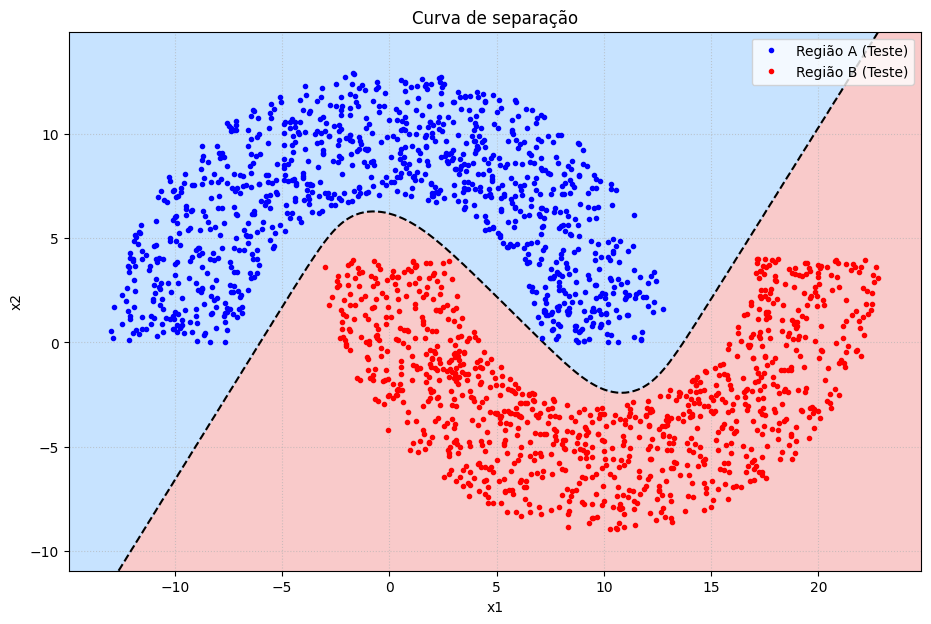

In [61]:
# Curva de separação

x1_min, x1_max = xteste[:, 0].min() - 2, xteste[:, 0].max() + 2
x2_min, x2_max = xteste[:, 1].min() - 2, xteste[:, 1].max() + 2

xx, yy = np.meshgrid(np.linspace(x1_min, x1_max, 200),
                     np.linspace(x2_min, x2_max, 200))

grid_data = np.c_[xx.ravel(), yy.ravel()]
Nt_grid = grid_data.shape[0]

x_bias_grid = np.hstack((np.ones((Nt_grid, 1)), grid_data))

L = len(Nn) - 1
Y = {}
Y_bias = {}

Y_bias[0] = x_bias_grid.T

for i in range(1, L + 1):
  l_idx = i - 1

  n_in = Nn[l_idx] + 1
  n_out = Nn[i]

  Wi = W_final[:n_out, :n_in, l_idx]

  V = Wi @ Y_bias[i-1]
  Y[i] = np.tanh(V)

  if i < L:
    Y_bias[i] = np.vstack((np.ones((1, Nt_grid)), Y[i]))

Z = Y[L]

Z = Z.reshape(xx.shape)

plt.figure(figsize=(11, 7))

plt.contourf(xx, yy, Z, levels=[-1, 0, 1], colors=['#F8BDBD', '#BADCFF'], alpha=0.8)
plt.contour(xx, yy, Z, levels=[0], colors='black', linestyles='--')

pontosA = xteste[dteste.ravel() == 1]
plt.plot(pontosA[:, 0], pontosA[:, 1], 'b.', label='Região A (Teste)')

pontosB = xteste[dteste.ravel() == -1]
plt.plot(pontosB[:, 0], pontosB[:, 1], 'r.', label='Região B (Teste)')

plt.title('Curva de separação')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()